In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/test-data-ct/test_data_100k.csv
/kaggle/input/fmedia/users.csv
/kaggle/input/fmedia/purchases.csv
/kaggle/input/train-data-ct/train_data_200k.csv


**Данные:**
Для выполнения задания предоставляется 2 CSV файла:
1. Данные о пользователях (users.csv). 
  1. Столбцы и формат:
    1. id: integer - уникальный идентификатор пользователя
    2. registration_date: date - дата регистрации в формате YYYY-MM-DD
2. Данные о покупках (purchases.csv)
  1. Столбцы и формат:
    1. id: integer - уникальный идентификатор покупки
    2. created_at: date - дата покупки в формате YYYY-MM-DD
    3. amount: float - сумма покупки
    4. user_id: integer - идентификатор пользователя, использовать как внешний ключ к данным о пользователях

**Задание:**
Необходимо построить когортный отчет, в котором за когорту принимается неделя регистрации пользователя, а за метрику поведения сумму покупок в последующие недели после регистрации.**

Импортируем нужные библиотеки, пропишем пути к файлам и загрузим данные:

In [41]:
import random
import seaborn as sns
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
purchases = '../input/fmedia/purchases.csv'
users = '../input/fmedia/users.csv'

In [43]:
p = pd.read_csv(purchases, parse_dates=['created_at'])
u = pd.read_csv(users, parse_dates=['registration_date']) 

Переименуем поле "id" в таблице users для удобства объединения таблиц:

In [44]:
u.rename(columns = {'id':'user_id'}, inplace = True)
u

,user_id,registration_date
0,1,2021-01-01
1,2,2021-01-01
2,3,2021-01-01
3,4,2021-01-01
4,5,2021-01-01
...,...,...
2192,2219,2021-06-14
2193,2220,2021-06-14
2194,2221,2021-06-15
2195,2222,2021-06-15


Объединяем таблицы purchases и users по полю "user_id":

In [45]:
mix = pd.merge(p, u, how='left', on=['user_id'])
mix.columns = ['id', 'created_at', 'user_id', 'amount', 'registration_date']
mix

,id,created_at,user_id,amount,registration_date
0,4784888,2021-01-05,4.0,30,2021-01-04
1,4785519,2021-01-05,5.0,30,2021-01-04
2,4785556,2021-01-05,5.0,30,2021-01-04
3,4786595,2021-01-05,5.0,30,2021-01-04
4,4787641,2021-01-05,5.0,30,2021-01-04
...,...,...,...,...,...
39101,6510618,2021-06-15,9.0,745,2021-02-22
39102,6510652,2021-06-15,3.0,1432,2021-04-09
39103,6510788,2021-06-15,2.0,1738,2021-05-03
39104,6510878,2021-06-15,25.0,249,2021-01-20


Добавим столбец "registration_week", в котором укажем неделю регистрации пользователя

In [46]:
mix['registration_week'] = mix.registration_date.apply(lambda x: x.strftime('%W'))
mix

,id,created_at,user_id,amount,registration_date,registration_week
0,4784888,2021-01-05,4.0,30,2021-01-04,01
1,4785519,2021-01-05,5.0,30,2021-01-04,01
2,4785556,2021-01-05,5.0,30,2021-01-04,01
3,4786595,2021-01-05,5.0,30,2021-01-04,01
4,4787641,2021-01-05,5.0,30,2021-01-04,01
...,...,...,...,...,...,...
39101,6510618,2021-06-15,9.0,745,2021-02-22,08
39102,6510652,2021-06-15,3.0,1432,2021-04-09,14
39103,6510788,2021-06-15,2.0,1738,2021-05-03,18
39104,6510878,2021-06-15,25.0,249,2021-01-20,03


Сгруппируем датасет по неделе регистрации пользователя; также добавим столбцы с датой покупки, количеством пользователей, id пользователя и суммой покупок

In [47]:
grouped = mix.groupby(['registration_week', 'created_at'])

cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'id': pd.Series.nunique,
                       'amount': np.sum})

cohorts.rename(columns={'user_id': 'TotalUsers',
                        'amount': 'TotalPurchases'}, inplace=True)
cohorts

TotalUsers  id  TotalPurchases
registration_week created_at                                
00                2021-01-14         1.0   2              46
                  2021-01-22         1.0   1               4
                  2021-01-27         1.0   1              17
                  2021-02-10         1.0   1              23
                  2021-05-18         1.0  11             198
...                                  ...  ..             ...
21                2021-06-15         2.0   2            4028
23                2021-06-12         1.0   1            2191
                  2021-06-13         6.0  27           59477
                  2021-06-14         4.0  38           83918
                  2021-06-15         1.0   1            2144

[1433 rows x 3 columns]

Добавим столбец "Cohort period" для определения периода когорты

In [48]:
def cohort_period(df):
     df['CohortPeriod'] = np.arange(len(df)) + 1
     return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.tail(6)

TotalUsers  id  TotalPurchases  CohortPeriod
registration_week created_at                                              
21                2021-06-14         2.0   7           14098            18
                  2021-06-15         2.0   2            4028            19
23                2021-06-12         1.0   1            2191             1
                  2021-06-13         6.0  27           59477             2
                  2021-06-14         4.0  38           83918             3
                  2021-06-15         1.0   1            2144             4

In [49]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['registration_week', 'CohortPeriod'], inplace=True)

In [51]:
cohorts_final = cohorts['TotalPurchases'].unstack(0)
cohorts_final

registration_week,00,01,02,03,04,05,06,07,08,09,...,13,14,15,16,17,18,19,20,21,23
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,46.0,210.0,110.0,517.0,677.0,458.0,1180.0,1905.0,4453.0,921.0,...,9247.0,1400.0,1470.0,9546.0,88660.0,10442.0,1832.0,1893.0,4028.0,2191.0
2,4.0,360.0,190.0,773.0,5174.0,1332.0,9968.0,4445.0,25188.0,7423.0,...,15852.0,11354.0,1470.0,6364.0,1713.0,15685.0,10992.0,1912.0,50350.0,59477.0
3,17.0,120.0,295.0,1965.0,5572.0,451.0,7577.0,1905.0,67254.0,23267.0,...,2642.0,12891.0,1470.0,1591.0,86955.0,19118.0,7406.0,1925.0,34238.0,83918.0
4,23.0,150.0,188.0,1187.0,3582.0,451.0,5402.0,2540.0,74396.0,14859.0,...,3977.0,5689.0,7655.0,1620.0,5118.0,24332.0,12954.0,3847.0,18126.0,2144.0
5,198.0,280.0,188.0,3234.0,7960.0,2995.0,11745.0,1270.0,73745.0,16696.0,...,1321.0,2822.0,36569.0,4887.0,5118.0,20856.0,11096.0,3894.0,26182.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,NaN,4734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,NaN,3631.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,NaN,4445.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим heatmap по финальной таблице с когортами:

<AxesSubplot:title={'center':'Cohorts'}, xlabel='CohortPeriod', ylabel='registration_week'>

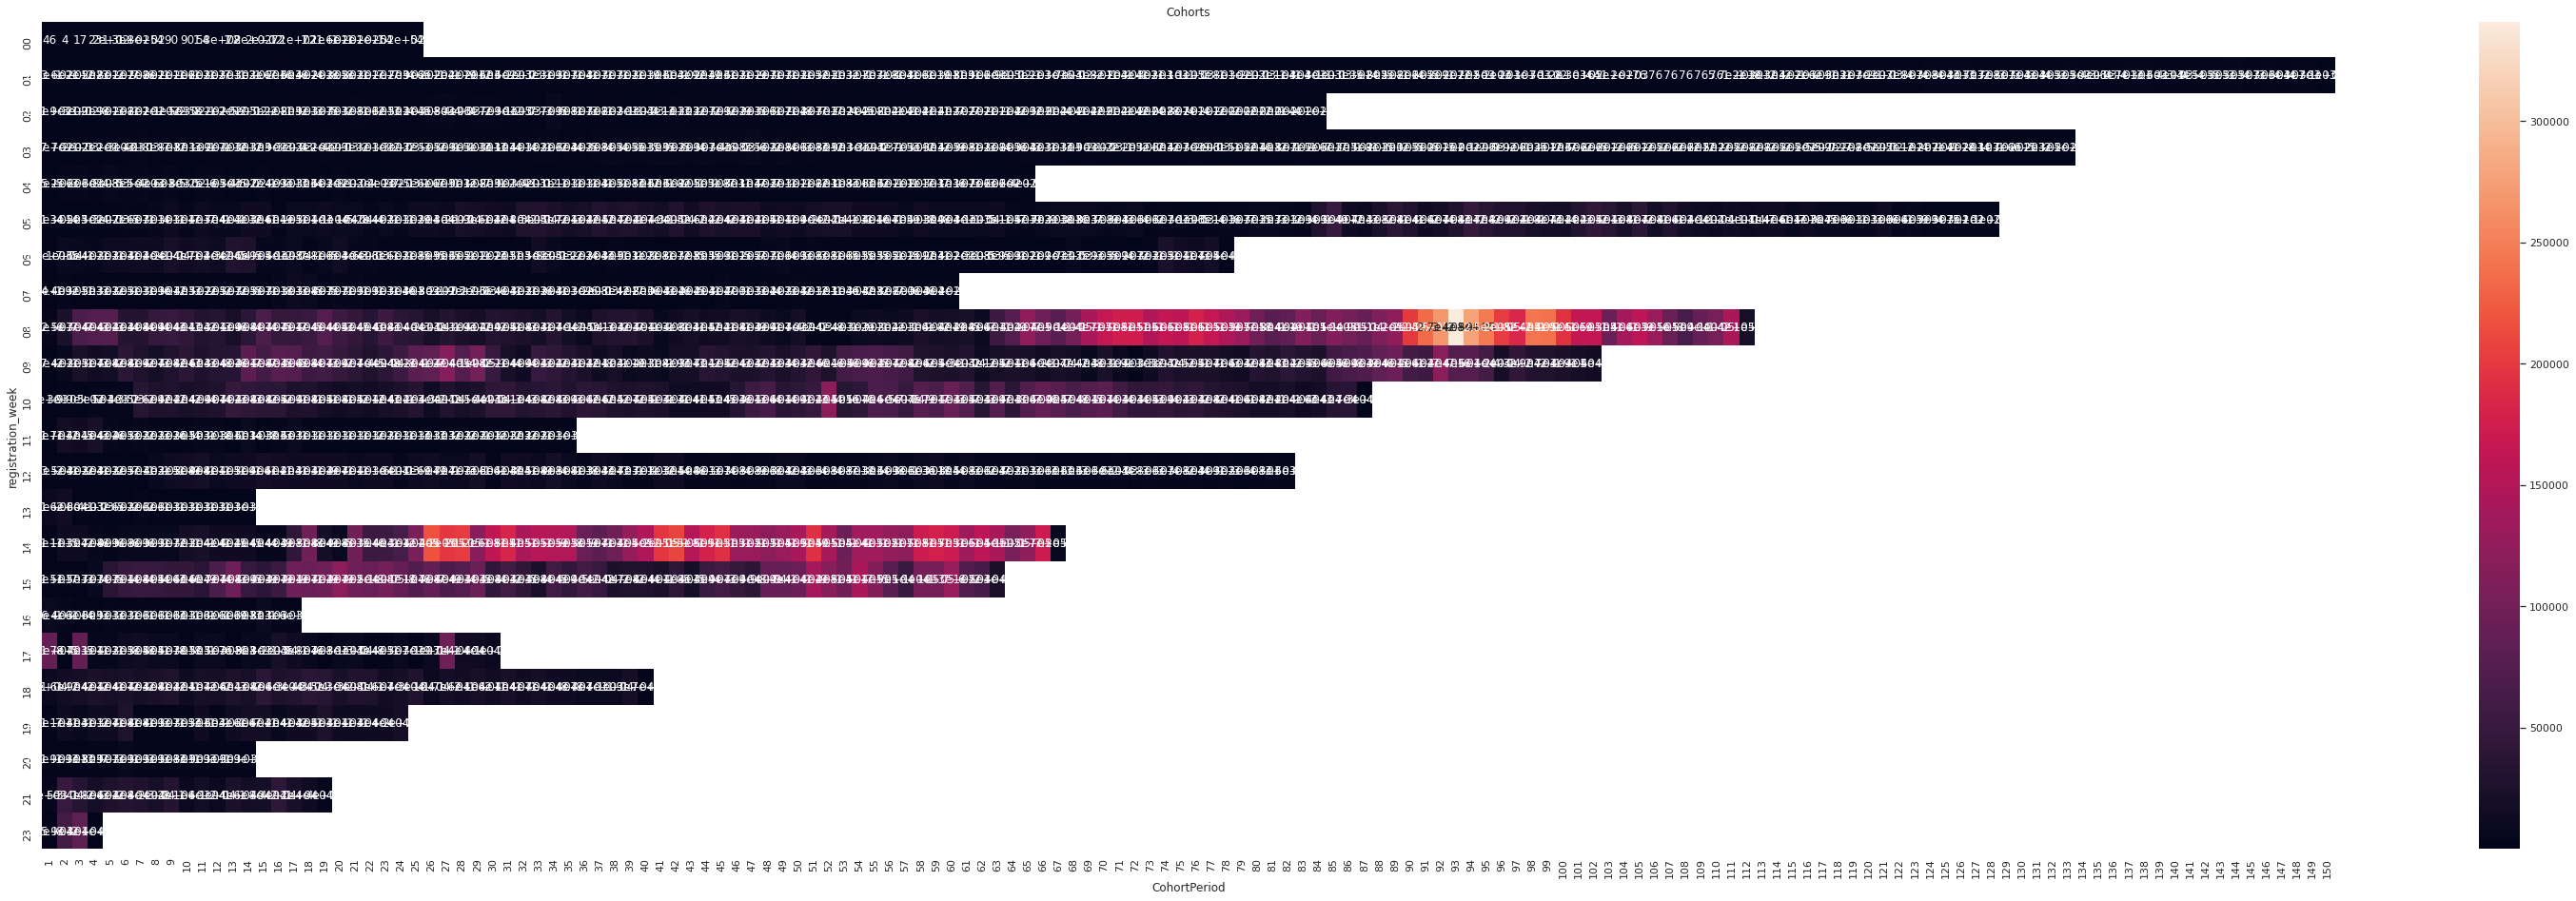

In [52]:
sns.set(style='white')

plt.figure(figsize=(54, 16))
plt.title('Cohorts')
sns.heatmap(cohorts_final.T, mask=cohorts_final.T.isnull(), annot=True)